In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import os
import plotly.graph_objects as go
import seaborn as sns
import plotly.express as px

# 데이터 불러오기


In [ ]:
# 데이터 경로 지정 및 읽어오기
data_path = '/content/drive/MyDrive/project3/holidays_events.csv'
holidays_events = pd.read_csv(data_path)
# 데이터 경로 지정 및 읽어오기
data_path = '/content/drive/MyDrive/project3/oil.csv'
oil = pd.read_csv(data_path)
# 데이터 경로 지정 및 읽어오기
data_path = '/content/drive/MyDrive/project3/sample_submission.csv'
sample_submission = pd.read_csv(data_path)
# 데이터 경로 지정 및 읽어오기
data_path = '/content/drive/MyDrive/project3/stores.csv'
stores = pd.read_csv(data_path)
# 데이터 경로 지정 및 읽어오기
data_path = '/content/drive/MyDrive/project3/test.csv'
test = pd.read_csv(data_path)
# 데이터 경로 지정 및 읽어오기
data_path = '/content/drive/MyDrive/project3/train.csv'
train = pd.read_csv(data_path)
# 데이터 경로 지정 및 읽어오기
data_path = '/content/drive/MyDrive/project3/transactions.csv'
transactions = pd.read_csv(data_path)


In [ ]:
import tensorflow as tf

In [ ]:
train.head()

,id,date,store_nbr,family,sales,onpromotion
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0
1,1,2013-01-01,1,BABY CARE,0.0,0
2,2,2013-01-01,1,BEAUTY,0.0,0
3,3,2013-01-01,1,BEVERAGES,0.0,0
4,4,2013-01-01,1,BOOKS,0.0,0


In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000888 entries, 0 to 3000887
Data columns (total 6 columns):
 #   Column       Dtype  
---  ------       -----  
 0   id           int64  
 1   date         object 
 2   store_nbr    int64  
 3   family       object 
 4   sales        float64
 5   onpromotion  int64  
dtypes: float64(1), int64(3), object(2)
memory usage: 137.4+ MB


In [ ]:
from datetime import datetime, date
train['date'] = pd.to_datetime(train['date'])
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000888 entries, 0 to 3000887
Data columns (total 6 columns):
 #   Column       Dtype         
---  ------       -----         
 0   id           int64         
 1   date         datetime64[ns]
 2   store_nbr    int64         
 3   family       object        
 4   sales        float64       
 5   onpromotion  int64         
dtypes: datetime64[ns](1), float64(1), int64(3), object(1)
memory usage: 137.4+ MB


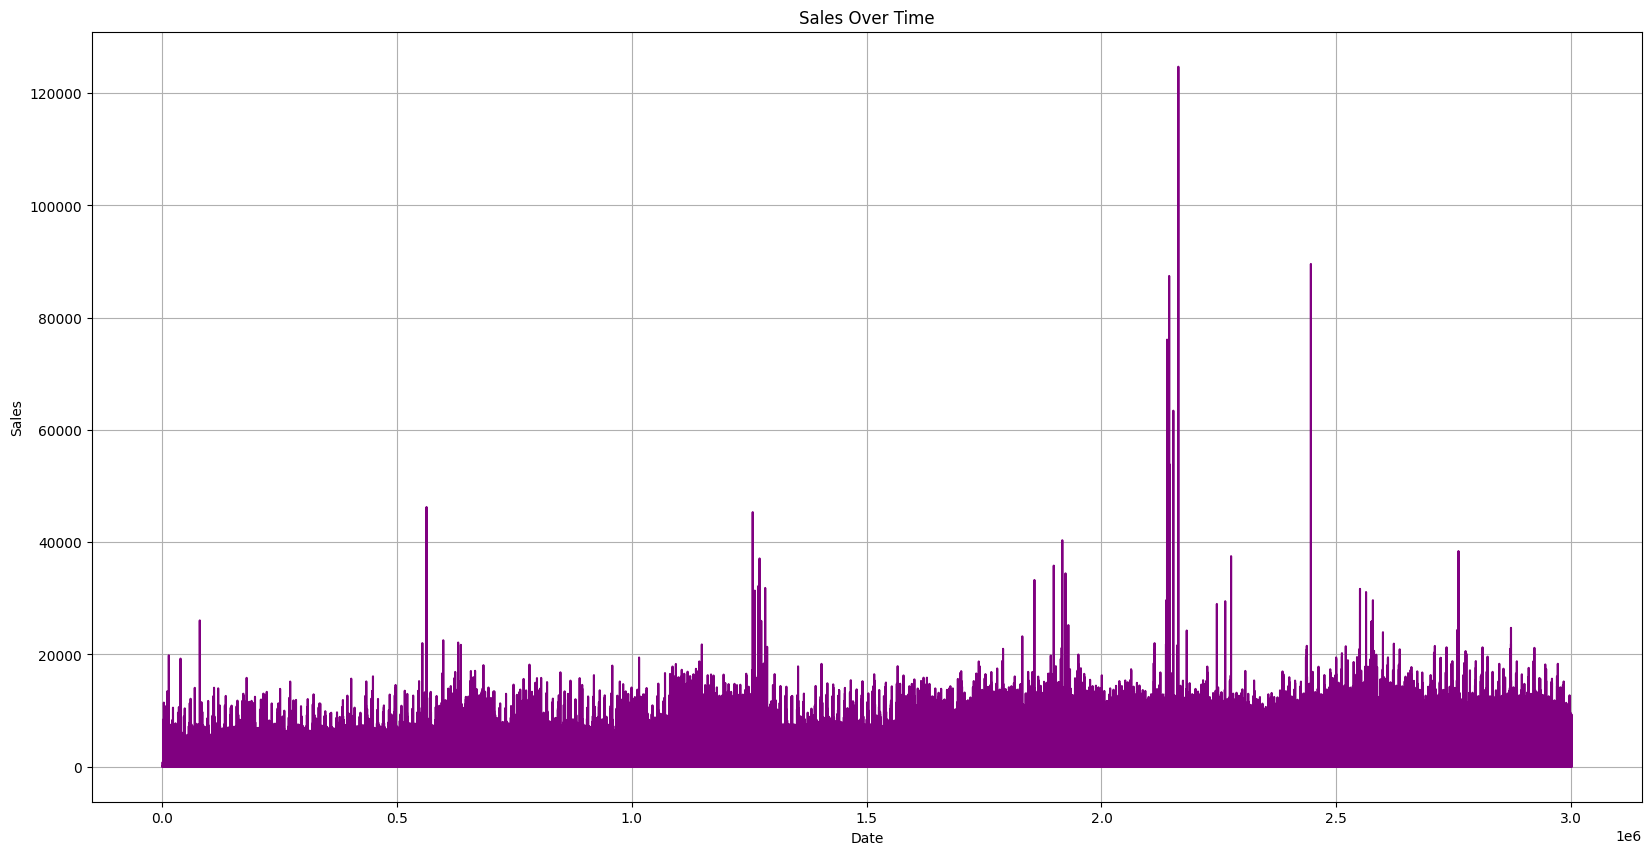

In [ ]:
plt.figure(figsize=(20, 10))
plt.plot(train.index, train['sales'], color='purple', linestyle='-')
plt.title('Sales Over Time')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.grid(True)
plt.show()


범주형 데이터 인코딩

In [ ]:

# 'family' 열을 원-핫 인코딩
encoded_family = pd.get_dummies(train['family'], prefix='family')

# 인코딩된 값 확인
print("Encoded values:")
print(encoded_family)

# 인코딩된 데이터프레임과 원래 데이터프레임을 합치기
train_encoded = pd.concat([train, encoded_family], axis=1)

# 인코딩된 데이터프레임 확인
print("\nEncoded dataframe:")
print(train_encoded)


Encoded values:
         family_AUTOMOTIVE  family_BABY CARE  family_BEAUTY  family_BEVERAGES  \
0                     True             False          False             False   
1                    False              True          False             False   
2                    False             False           True             False   
3                    False             False          False              True   
4                    False             False          False             False   
...                    ...               ...            ...               ...   
3000883              False             False          False             False   
3000884              False             False          False             False   
3000885              False             False          False             False   
3000886              False             False          False             False   
3000887              False             False          False             False   

         fa

In [ ]:
# 원래 값과 인코딩된 값의 대응 관계 확인
print("\nMapping between original and encoded values:")
for original_value in train['family'].unique():
    encoded_column = f'family_{original_value}'  # 원-핫 인코딩된 열의 이름
    print(f"{original_value} -> {encoded_column}")


Mapping between original and encoded values:
AUTOMOTIVE -> family_AUTOMOTIVE
BABY CARE -> family_BABY CARE
BEAUTY -> family_BEAUTY
BEVERAGES -> family_BEVERAGES
BOOKS -> family_BOOKS
BREAD/BAKERY -> family_BREAD/BAKERY
CELEBRATION -> family_CELEBRATION
CLEANING -> family_CLEANING
DAIRY -> family_DAIRY
DELI -> family_DELI
EGGS -> family_EGGS
FROZEN FOODS -> family_FROZEN FOODS
GROCERY I -> family_GROCERY I
GROCERY II -> family_GROCERY II
HARDWARE -> family_HARDWARE
HOME AND KITCHEN I -> family_HOME AND KITCHEN I
HOME AND KITCHEN II -> family_HOME AND KITCHEN II
HOME APPLIANCES -> family_HOME APPLIANCES
HOME CARE -> family_HOME CARE
LADIESWEAR -> family_LADIESWEAR
LAWN AND GARDEN -> family_LAWN AND GARDEN
LINGERIE -> family_LINGERIE
LIQUOR,WINE,BEER -> family_LIQUOR,WINE,BEER
MAGAZINES -> family_MAGAZINES
MEATS -> family_MEATS
PERSONAL CARE -> family_PERSONAL CARE
PET SUPPLIES -> family_PET SUPPLIES
PLAYERS AND ELECTRONICS -> family_PLAYERS AND ELECTRONICS
POULTRY -> family_POULTRY
PREP

In [ ]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler

# 데이터 전처리
sales = train['sales'].values.reshape(-1, 1)
scaler = MinMaxScaler()
sales_scaled = scaler.fit_transform(sales)

# 시계열 데이터를 X_train과 y_train으로 변환
X_train, y_train = [], []
look_back = 30  # 입력 데이터의 길이 (과거 30일 데이터를 사용)
for i in range(len(sales_scaled) - look_back):
    X_train.append(sales_scaled[i:i+look_back, 0])
    y_train.append(sales_scaled[i+look_back, 0])
X_train, y_train = np.array(X_train), np.array(y_train)

# LSTM 모델 정의
model = Sequential([
    LSTM(units=50, input_shape=(X_train.shape[1], 1)),
    Dense(units=1)
])

# 모델 컴파일
model.compile(optimizer='adam', loss='mean_squared_error')

# 모델 훈련
model.fit(X_train, y_train, epochs=100, batch_size=32)


Epoch 1/100
93777/93777 [==============================] - 1334s 14ms/step - loss: 4.0940e-05
Epoch 2/100
93777/93777 [==============================] - 1326s 14ms/step - loss: 1.5388e-05
Epoch 3/100
93777/93777 [==============================] - 1300s 14ms/step - loss: 1.3146e-05
Epoch 4/100
93777/93777 [==============================] - 1341s 14ms/step - loss: 1.2192e-05
Epoch 5/100
93777/93777 [==============================] - 1356s 14ms/step - loss: 1.1512e-05
Epoch 6/100
93777/93777 [==============================] - 1360s 14ms/step - loss: 1.1072e-05
Epoch 7/100
93777/93777 [==============================] - 1355s 14ms/step - loss: 1.0811e-05
Epoch 8/100
93777/93777 [==============================] - 1360s 15ms/step - loss: 1.0551e-05
Epoch 9/100
93777/93777 [==============================] - 1372s 15ms/step - loss: 1.0358e-05
Epoch 10/100
93777/93777 [==============================] - 1357s 14ms/step - loss: 1.0199e-05
Epoch 11/100
93777/93777 [==============================] -